# Diffraction Studies Automation
written by: Taylor Contreras, Feb 5 2021

This code controls the automation of the oscilliscope and the motors to take measurements of the light intensity of a SiPM. An LED is aligned with a diffraction grating in front of the SiPM. The SiPM and LED are on tracks that can move vertically. This allows the calibration of the SiPM with no light and for the measurement of light intensity as a function of angle from the diffraction grating. 

See other notebooks for more details and tests (PyVisa_tutorial.ipynb, Ardruino_testing.ipynb, Motot_control_testing.ipynb)

In [1]:
import pyvisa
import pyfirmata
import time
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import signal
from IPython.display import display, clear_output

#### Connect to the oscilliscope

In [12]:
# Before running, connect the laptop to the oscilloscope through the USBTMC
rm = pyvisa.ResourceManager()
# Use the name this prints to grab the instrument in the next step
rm.list_resources() 

('USB0::0x05FF::0x1023::4206N21552::INSTR', 'ASRL3::INSTR', 'ASRL10::INSTR')

In [11]:
# Grabs the instrument and prints name
scope = rm.open_resource('USB0::0x05FF::0x1023::4206N21552::INSTR')

#### Connect to the Arduino

In [14]:
# Use Arduino IDE to find the port name
# under Tools->Port
# This time is was COM3
board = pyfirmata.Arduino('COM3') 

#### Global variables

In [48]:
MAX_Z = 231. # Mazimum allowable height in mm
GRATING_LED_POSITION = 70. # LED position for alignment with grating
BELOW_GRATING_LED_POSITION = 67 # LED position for alignment below grating
BELOW_MOUNT_LED_POSITION = 45 # LED position for alignment below grating
SIPM_OFFSET = 13.86 #14.355 # Difference in height between SiPM and LeD for direct alignment. LED is lower.
NUM_SWEEPS = 15

# Functions

In [5]:
def MeasurePeaktoPeak():
    """
    Measures the peak to peak voltage coming from the oscilliscope and
    returns an array of the maxes for a given number of aquisitions.
    """
    force_trigger_rate = 0.1 # s
    trigger_level = 0.890 # V
    
    # Waits 5 seconds after oscilliscope is idle before 
    # setting up new acquisition
    scope.timeout = 5000
    scope.clear()
    r = scope.query(r"""vbs? 'return=app.WaitUntilIdle(.0003)' """)
    
    # Set up aquisition by stopping trigger 
    scope.write(r"""vbs 'app.acquisition.triggermode = "stopped" ' """)
    # Set up trigger (in this case we trigger on the C2 which has the trigger for the input waveform to the LED)
    scope.write(r"""vbs 'app.acquisition.trigger.C2level = %f ' """ % trigger_level)
    scope.write(r"""vbs 'app.acquisition.triggermode = "single" ' """)
    scope.write(r"""vbs 'app.acquisition.horizontal.maximize = "FixedSampleRate" ' """)

    # Set up Measurements, clearing previous measurements
    scope.write(r"""vbs 'app.clearsweeps ' """)
    scope.write(r"""vbs 'app.measure.clearall ' """)
    scope.write(r"""vbs 'app.measure.clearsweeps ' """)

    # Setup averaging waveform
    scope.write(r"""vbs 'app.math.f1.operator1 = "average" ' """)
    scope.write(r"""vbs 'app.math.f1.source1 = "C1" ' """)
    
    for i in range(0,NUM_SWEEPS):
        r = scope.query(r"""vbs? 'return=app.acquisition.acquire( 0.0003 , True ) ' """)
        r = scope.query(r"""vbs? 'return=app.WaitUntilIdle(.0003)' """)
        if r==0:
            print("Time out from WaitUntilIdle, return = {0}".format(r))


    # Setup measurement of peak to peak voltage based on average waveform
    scope.write(r"""vbs 'app.measure.showmeasure = true ' """)
    scope.write(r"""vbs 'app.measure.statson = true ' """)
    scope.write(r"""vbs 'app.measure.p1.view = true ' """)
    scope.write(r"""vbs 'app.measure.p1.paramengine = "pkpk" ' """ ) 
    scope.write(r"""vbs 'app.measure.p1.source1 = "F1" ' """)
    r = scope.query(r"""vbs? 'return=app.acquisition.acquire( 0.003 , True ) ' """)
    r = scope.query(r"""vbs? 'return=app.WaitUntilIdle(.003)' """)

    # Read back Measurement Results
    pkpk = scope.query(r"""vbs? 'return=app.measure.p1.out.result.value' """)

    return ConvertToFloat(pkpk)

def step(step_pin=9, dir_pin=8, direction=0):
    """
    Moves the stepper motor one microstep.
    
    Inputs:
        step_pin (int): pin on arduino to control stepping
        dir_pin (int): pin on arduino to control direction
        direction (0 or 1): direction motor will move when stepped
    """
    board.digital[dir_pin].write(direction) # direction pin
    board.digital[step_pin].write(1)
    #time.sleep(.01) # lowest windows can get is 10ms, motor runs faster if we remove the time delay 
    board.digital[step_pin].write(0)
    #time.sleep(.01)
    return

def MoveMotor(distance, motor='sipm', ignore_limits=False):
    """
    Moves either the sipm or the LED a certain distance up or down.
    
    Inputs:
        distance (float): the distance to move the device, in mm
        motor ('sipm' or 'led'): specifies which device to move
        ignore_limits (True/False):
    """
    
    # Calculate number of steps needed
    dx_per_step = .005 # mm
    num_steps = int(distance // dx_per_step)
    MoveSteps(num_steps, motor, ignore_limits)
       
    return

def SetToZero():
    """
    Setboth motors to zero steps.
    
    Inputs:
        steps (int): steps value to move to
        motor ('sipm' or 'led'): specifies which device to move
    """
    SetSteps(0, "sipm")
    SetSteps(0, "led")

def SetToTop():
    """
    Set both motors to zero steps.
    
    Inputs:
        steps (int): steps value to move to
        motor ('sipm' or 'led'): specifies which device to move
    """
    for motor in ["led","sipm"]:
        position = GetCurrentPosition(motor)
        MoveMotor(MAX_Z-position-5, motor)
    
def SetSteps(steps, motor="sipm"):
    """
    Sets either the sipm or the LED tp a certain number of steps.
    
    Inputs:
        steps (int): steps value to move to
        motor ('sipm' or 'led'): specifies which device to move
    """
    current_steps = GetCurrentNumSteps(motor)
    steps_to_move = steps - current_steps
    MoveSteps(steps_to_move, motor)

def MoveSteps(num_steps, motor='sipm', ignore_limits=False):
    """
    Moves either the sipm or the LED a certain number of steps.
    
    Inputs:
        num_steps (int): number of steps to move the device (positive = up, negative = down)
        motor ('sipm' or 'led'): specifies which device to move
        ignor_limits (True/False): 
    """
    num_steps = int(num_steps)
    if num_steps == 0: return
    
    dx_per_step = .005 # mm
    
    # Specify stepper motor inputs
    if motor == 'sipm':
        step_pin = 8
        dir_pin = 9
    elif motor == 'led':
        step_pin = 10
        dir_pin = 11
    else:
        print('Not a valid motor option')
        return
       
    if num_steps < 0:
        motor_direction = 0
    else:
        motor_direction = 1
    
    current_num_steps = GetCurrentNumSteps(motor)
    new_position = (current_num_steps+num_steps)*dx_per_step
    if not ignore_limits and (new_position > MAX_Z or new_position < 0.0):
        print('Warning: too large of distance to move motor')
        return
    
    # Step the motor
    for i in range(abs(num_steps)):
        step(step_pin, dir_pin, motor_direction)
        #time.sleep(0.01)
        
    WriteNewNumSteps(current_num_steps+num_steps, motor)
    
    return

def GetCurrentNumSteps(motor='sipm'):
    """
    Reads the text file that stores the current number of step the sipm and motor
    have moved and returns the position based on the motor input in mm
    
    Inputs:
        motor (str): 'sipm' or 'led'
    """
    rows = []
    with open('positions.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            rows.append(row)
        
    if motor=='sipm':
        return int(rows[0][0])
    elif motor=='led':
        return int(rows[0][1])
    else:
        print('Not a valid input')
        return
    
def GetCurrentPosition(motor='sipm'):
    """
    Reads the text file that stores the current position of the sipm and motor
    and returns the position based on the motor input in mm
    
    Inputs:
        motor (str): 'sipm' or 'led'
    """
    dx_per_step = .005 # mm
    rows = []
    with open('positions.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            rows.append(row)
        
    if motor=='sipm':
        return int(rows[0][0])*dx_per_step
    elif motor=='led':
        return int(rows[0][1])*dx_per_step
    else:
        print('Not a valid input')
        return

def WriteNewNumSteps(position, motor='sipm'):
    """
    Writes to the text file the new number of steps of the device from the bottom 
    
    Inputs:
        motor (str): 'sipm' or 'led'
    """
    if motor != "sipm" and motor != "led":
        print('Not a valid input')
        return
        
    sipm_pos = GetCurrentNumSteps('sipm')
    led_pos = GetCurrentNumSteps('led')
    
    with open('positions.csv', 'w', newline='') as file:
        file.truncate()
        writer = csv.writer(file)

        if motor=='sipm':
            writer.writerow([position,led_pos])
            return
        else:
            writer.writerow([sipm_pos,position])
            return
        
def Align(align_to='grating'):
    """
    Moves them to align with the diffraction grating and saves 
    the position in the cvs file, if to_lens=True, else aligns
    the sipm and led away from the diffraction grating.
    
    inputs
        align_to (str): Align the LED and sipm to the diffraction
            grating ('grating'), the substrate without the grating 
            ('below_grating'), or below the mount ('below_mount')
    """
    
    
    sipm_pos = GetCurrentPosition(motor='sipm')
    led_pos = GetCurrentPosition(motor='led')
    
    if align_to=='grating':
        MoveMotor(GRATING_LED_POSITION-led_pos, "led")
        MoveMotor(GRATING_LED_POSITION+SIPM_OFFSET-sipm_pos, "sipm")
    elif align_to=='below_grating':
        MoveMotor(BELOW_GRATING_LED_POSITION-led_pos, "led")
        MoveMotor(BELOW_GRATING_LED_POSITION+SIPM_OFFSET-sipm_pos, "sipm")
    elif align_to=='below_mount':
        MoveMotor(BELOW_MOUNT_LED_POSITION-led_pos, "led")
        MoveMotor(BELOW_MOUNT_LED_POSITION+SIPM_OFFSET-sipm_pos, "sipm")
    else:
        print("Incorrect input for align_to (options: 'grating', 'below_grating', 'below_mount')")
    
    return

def ConvertToFloat(val):
    """
    Extracts a float from a complex string
    """
    for token in val.split():
        floatval = ''
        try:
           floatval = float(token)
        except ValueError:
            continue
        if type(floatval)==float:
            return floatval
    return np.nan

## Reset Zero

In [23]:
# Unplug motors and move them to bottom first
WriteNewNumSteps(0,"sipm")
WriteNewNumSteps(0,"led")

In [26]:
Align('grating')

In [24]:
SetToZero()

## Get Alignment

In [46]:
"""
Run this after a change to the setup to get the new offset between SiPM and LED.
Set both to bottom then move SiPM up 40mm to have it move across the LED. 
The peak position represents the offset
"""
SetToZero()
MoveMotor(BELOW_MOUNT_LED_POSITION,"sipm")
MoveMotor(BELOW_MOUNT_LED_POSITION,"led")
distance_to_move = 30.
distance_per_step = 0.5
num_steps = int(distance_to_move/distance_per_step)
maxes = []
positions = []
steps = []
# Measure voltage at each step
for i in range(num_steps):
    MoveMotor(distance_per_step, 'sipm')
    max = MeasurePeaktoPeak()
    maxes.append(max)
    current_position = GetCurrentPosition('sipm')
    current_steps = GetCurrentNumSteps('sipm')
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_steps)+": "+str(current_position)+" ("+str(max)+")")
    positions.append(current_position)
    steps.append(current_steps)

'60/60: 74.69500000000001 (0.00195682910270989)'

13.86


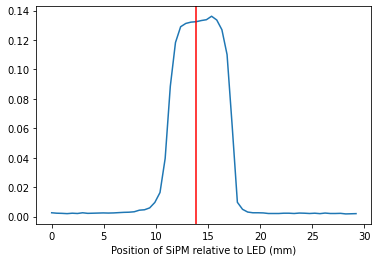

In [47]:
# Locate the peak and set the offset value as a global variable
rel_positions = np.array(positions) - positions[0]
plt.plot(rel_positions,maxes)
plt.xlabel("Position of SiPM relative to LED (mm)")
NoGrating_peaks, _ = signal.find_peaks(maxes, prominence=0.05)
NoGrating_widths = signal.peak_widths(maxes, NoGrating_peaks)
l = rel_positions[int(NoGrating_widths[2][0])]
r = rel_positions[int(NoGrating_widths[3][0])]
NoGrating_peak_pos = (r + l)/2
plt.axvline(NoGrating_peak_pos,color="r")
SIPM_OFFSET = abs(NoGrating_peak_pos)
print(SIPM_OFFSET)
# Remember to update global variable at the top of the workbook once a new SIPM_OFFSET is measured.

## Run Function

In [7]:
def ScanMaxes(width=40., num_measurements=200, align_to='grating'):
    """
    Scan the max signal across the sipm with and without
    the diffraction grating and save to a file. 
    """     
    # Align and measure
    Align(align_to)
    MoveMotor(-width/2.)
        
    # Measure voltage at each distance
    distance_to_move = width/num_measurements
    maxes = []
    positions_sipm = []
    position_led = GetCurrentPosition(motor='led')
    for i in range(num_measurements):
        clear_output(wait=True)
        display(str(i+1)+"/"+str(num_measurements))
        MoveMotor(distance_to_move, 'sipm')
        maxes.append(MeasurePeaktoPeak())
        positions_sipm.append(GetCurrentPosition())

    return position_led, positions_sipm, maxes

In [16]:
Align('grating')

'100/100'

Text(0, 0.5, 'SiPM Max Voltage')

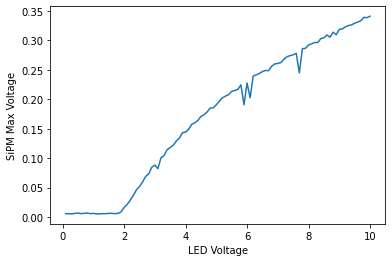

In [41]:
# Run to check voltage to intensity
num_measurements = 100
dV = .1
values = []
for i in range(num_measurements):
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_measurements))
    #scope.timeout = 5000
    #scope.clear()
    #r = scope.query(r"""vbs? 'return=app.WaitUntilIdle(5)' """)
    
    values.append(MeasurePeaktoPeak())
    time.sleep(2)
    
plt.plot([dV*(i+1) for i in range(num_measurements)], values)
plt.xlabel('LED Voltage')
plt.ylabel('SiPM Max Voltage')

In [43]:
values_250ns = values

Text(0, 0.5, 'SiPM Max Voltage')

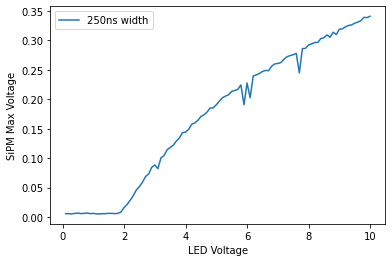

In [45]:
#values_50ns = values
#values_250ns = values
#plt.plot([1.0*(i+1) for i in range(num_measurements)], values_50ns, label='50ns width')
plt.plot([0.1*(i+1) for i in range(num_measurements)], values_250ns, label='250ns width')
plt.legend()
plt.xlabel('LED Voltage')
plt.ylabel('SiPM Max Voltage')

In [49]:
file_name = 'ledV_to_sipmV.csv'
with open(file_name, mode='w') as file:
    writer = csv.writer(file)
    
    writer.writerow(['50ns width'])
    writer.writerow([0.1*(i+1) for i in range(num_measurements)])
    writer.writerow(values_50ns)
    
    writer.writerow(['250ns width'])
    writer.writerow([0.1*(i+1) for i in range(num_measurements)])
    writer.writerow(values_250ns)
    

Text(0, 0.5, 'SiPM Max Voltage')

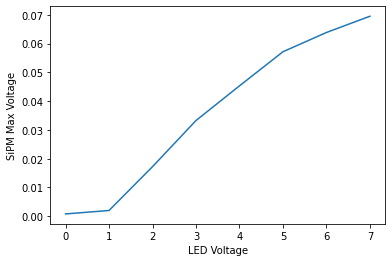

In [33]:
plt.plot([dV*i for i in range(num_measurements)], values)
plt.xlabel('LED Voltage')
plt.ylabel('SiPM Max Voltage')

In [67]:
Align("grating")

In [66]:
SetToZero()

In [59]:

def Run(file_name, voltage=5.0):
    width = 60.0 # mm
    num_measurements = 150 #300 
    # Create the file to hold the array of max signals
    with open(file_name, mode='w') as file:
        writer = csv.writer(file)

        print("With grating")
        position_led_g, positions_sipm_g, maxes_g = ScanMaxes(width, num_measurements, align_to='grating')
        writer.writerow(['with grating'])
        writer.writerow([position_led_g])
        writer.writerow(positions_sipm_g)
        writer.writerow(maxes_g)

        print('Below grating')
        position_led_bg, positions_sipm_bg, maxes_bg = ScanMaxes(width, num_measurements, align_to='below_grating')
        writer.writerow(['below grating'])
        writer.writerow([position_led_bg])
        writer.writerow(positions_sipm_bg)
        writer.writerow(maxes_bg)

#         print('Below mount')
#         position_led_bm, positions_sipm_bm, maxes_bm = ScanMaxes(width, num_measurements, align_to='below_mount')
#         writer.writerow(['below mount'])
#         writer.writerow([position_led_bm])
#         writer.writerow(positions_sipm_bm)
#         writer.writerow(maxes_bm)

        print('Saving Global Variables')
        writer.writerow(['Grating LED Position', GRATING_LED_POSITION])
        writer.writerow(['Below Grating LED Position',BELOW_GRATING_LED_POSITION])
        writer.writerow(['Below Mount LED Position', BELOW_MOUNT_LED_POSITION])
        writer.writerow(['Voltage', voltage])

    halfway = len(positions_sipm_g)//2
    plt.plot(np.array(positions_sipm_bg)-BELOW_GRATING_LED_POSITION, maxes_bg, label='below grating')
    plt.plot(np.array(positions_sipm_g)-GRATING_LED_POSITION, maxes_g, label='with grating')
#     plt.plot(np.array(positions_sipm_bm)-BELOW_MOUNT_LED_POSITION, maxes_bm, label='below mount')
    plt.legend()
    plt.ylabel('Max Voltage [V]')
    plt.xlabel('SiPM Position [mm]')

In [51]:
Align("below_grating")

In [58]:
MeasurePeaktoPeak()

0.0645624865137506

'150/150'

Saving Global Variables


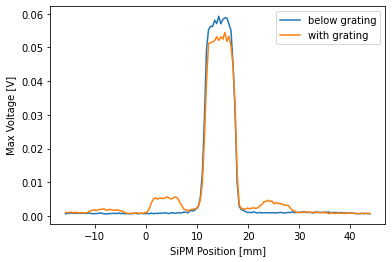

In [68]:
Run('run001_distilled_water_data_50ns_15sweeps.csv')

'150/150'

Saving Global Variables


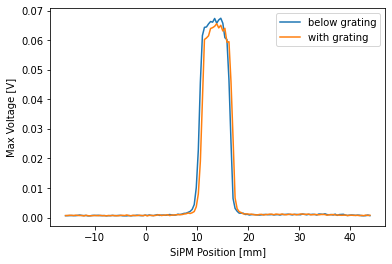

In [60]:
Run('distilled_water_data_50ns_15sweeps.csv')

'150/150'

Saving Global Variables


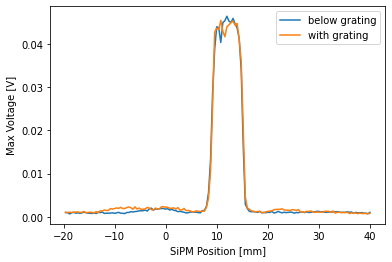

In [32]:
Run('distilled_water_data_50ns_10sweeps.csv')

'150/150'

Saving Global Variables


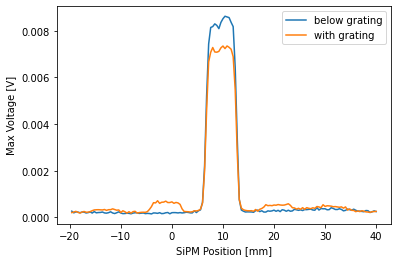

In [22]:
Run('distilled_water_data_attenuated_18.csv')

'150/150'

Saving Global Variables


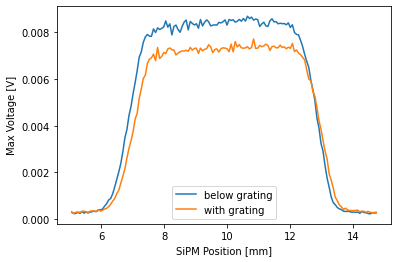

In [20]:
Run('distilled_water_data_attenuated_17.csv')

'150/150'

Saving Global Variables


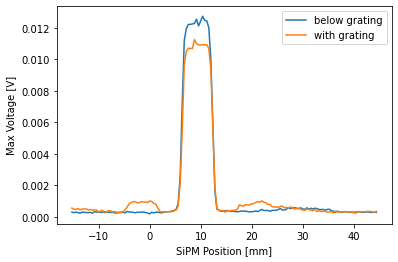

In [14]:
Run('distilled_water_data_attenuated_16.csv')

'150/150'

Saving Global Variables


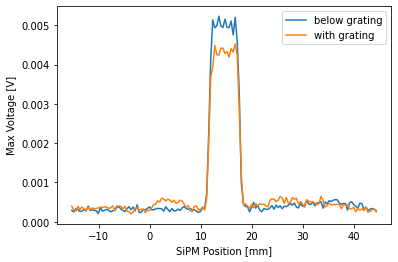

In [69]:
Run('distilled_water_data_attenuated_12.csv')

'150/150'

Saving Global Variables


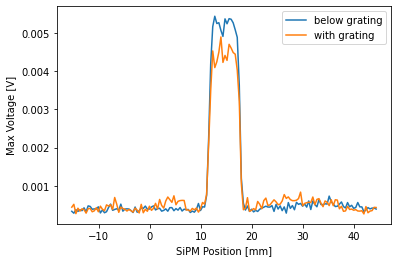

In [66]:
Run('distilled_water_data_attenuated_11.csv')

'60/60'

Saving Global Variables


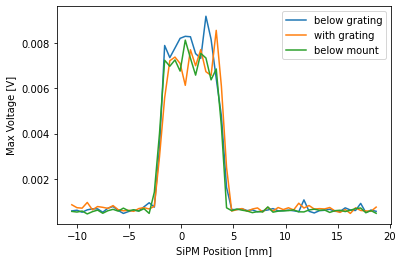

In [54]:
Run('distilled_water_data_attenuated_10.csv')

'300/300'

Saving Global Variables


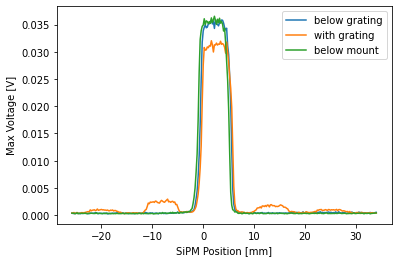

In [51]:
Run('distilled_water_data_attenuated_7.csv')

'150/150'

Saving Global Variables


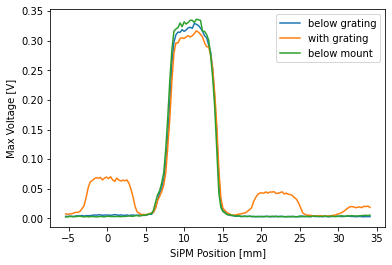

In [26]:
Run('distilled_water_data_40ns.csv')

'150/150'

Saving Global Variables


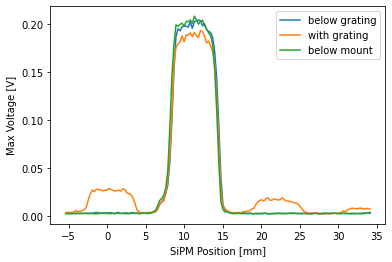

In [25]:
Run('distilled_water_data.csv')

In [34]:
Align('grating')

Text(0.5, 0, 'SiPM Position [mm]')

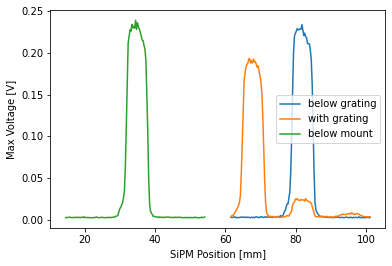

In [153]:
halfway = len(positions_sipm1)//2
plt.plot(np.array(positions_sipm_bg), maxes_bg, label='below grating')
plt.plot(np.array(positions_sipm_g)-(GRATING_LED_POSITION-BELOW_GRATING_LED_POSITION), maxes_g, label='with grating')
plt.plot(np.array(positions_sipm_bm)-(GRATING_LED_POSITION-BELOW_MOUNT_LED_POSITION), maxes_bm, label='below mount')
plt.legend()
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

Text(0.5, 0, 'SiPM Position [mm]')

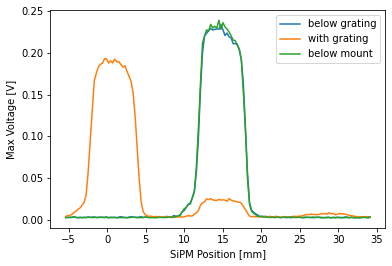

In [155]:
halfway = len(positions_sipm1)//2
plt.plot(np.array(positions_sipm_bg)-BELOW_GRATING_LED_POSITION, maxes_bg, label='below grating')
plt.plot(np.array(positions_sipm_g)-GRATING_LED_POSITION, maxes_g, label='with grating')
plt.plot(np.array(positions_sipm_bm)-BELOW_MOUNT_LED_POSITION, maxes_bm, label='below mount')
plt.legend()
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

Text(0.5, 0, 'SiPM Position [mm]')

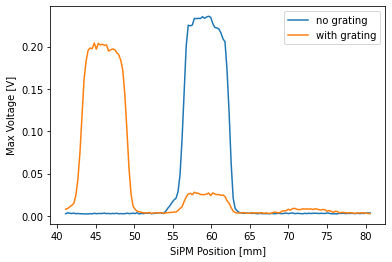

In [106]:
halfway = len(positions_sipm1)//2
plt.plot(np.array(positions_sipm_bg), maxes_bg, label='below grating')
plt.plot(np.array(positions_sipm_g)-(GRATING_LED_POSITION-BELOW_GRATING_LED_POSITION), maxes_g, label='with grating')
plt.plot(np.array(positions_sipm_bm)-(GRATING_LED_POSITION-BELOW_MOUNT_LED_POSITION), maxes_bm, label='below mount')
plt.legend()
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

Text(0.5, 0, 'SiPM Position [mm]')

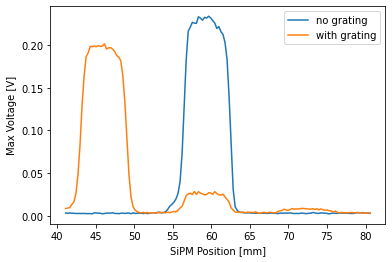

In [104]:
halfway = len(positions_sipm1)//2
plt.plot(np.array(positions_sipm1), maxes1, label='no grating')
plt.plot(np.array(positions_sipm2)-(GRATING_LED_POSITION-BELOW_GRATING_LED_POSITION), maxes2, label='with grating')
plt.legend()
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

In [23]:
MoveMotor(10,"led")

In [24]:
Align('grating')

In [22]:
MoveMotor(-20,"led")

Text(0.5, 0, 'SiPM Position [mm]')

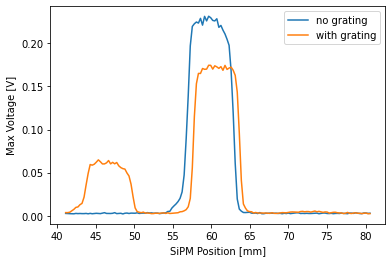

In [95]:
halfway = len(positions_sipm1)//2
plt.plot(np.array(positions_sipm1), maxes1, label='no grating')
plt.plot(np.array(positions_sipm2)-(GRATING_LED_POSITION-BELOW_GRATING_LED_POSITION), maxes2, label='with grating')
plt.legend()
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

Text(0.5, 0, 'SiPM Position [mm]')

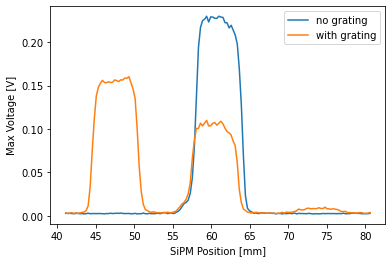

In [93]:
halfway = len(positions_sipm1)//2
plt.plot(np.array(positions_sipm1), maxes1, label='no grating')
plt.plot(np.array(positions_sipm2)-(GRATING_LED_POSITION-BELOW_GRATING_LED_POSITION), maxes2, label='with grating')
plt.legend()
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

In [126]:
Align(True)

In [129]:
MoveMotor(10,"sipm")

## During experiment:
1. Set sipm and LED to the top of the rods (note: power off the motors and move by hand)
2. Align the sipm and LED with the Align() function
3. Then procced with the measurement taking:
4. Move sipm some distance
5. Take oscilliscope measurements
7. After repeating for all desired sipm distances, close the connections
6. Output/plot the data

In [289]:
# Create the file to hold the positions of the sipm and led
# The sipm and led MUST BE positioned the very top of the rods (at 0.0)
with open('positions.csv', mode='w') as file:
    writer = csv.writer(file)
    writer.writerow([0, 0])

In [354]:
MoveSteps(100,motor='sipm',direction='up')
print(GetCurrentPosition(), GetCurrentPosition('led'))
print(GetCurrentNumSteps(), GetCurrentNumSteps('led'))

163.0 194.0
32600 38800


In [8]:
# Align the SiPM and LED to the diffraction grating
Align(with_lens=False)

In [333]:
print(GetCurrentPosition(), GetCurrentPosition('led'))

119.3 161.995


In [331]:
direction = 'up'

In [53]:
MoveMotor(40, 'led', 'down')

In [55]:
MoveMotor(30, 'sipm', 'down')

In [257]:
direction

'down'

In [332]:
# Measure voltage at each distance
distance_to_move = .1 # mm
num_measurements = 150
maxes = []
maxes.append(MeasurePeaktoPeak())
for i in range(num_measurements):
    print("Measurement:"+str(i))
    MoveMotor(distance_to_move, 'sipm', direction)
    maxes.append(MeasurePeaktoPeak())
maxes = [float(m) for m in maxes]
if direction == 'down': direction = 'up'
else: direction = 'down'

Measurement:0
26000 20 -1 0.005
Measurement:1
25980 20 -1 0.005
Measurement:2
25960 20 -1 0.005
Measurement:3
25940 20 -1 0.005
Measurement:4
25920 20 -1 0.005
Measurement:5
25900 20 -1 0.005
Measurement:6
25880 20 -1 0.005
Measurement:7
25860 20 -1 0.005
Measurement:8
25840 20 -1 0.005
Measurement:9
25820 20 -1 0.005
Measurement:10
25800 20 -1 0.005
Measurement:11
25780 20 -1 0.005
Measurement:12
25760 20 -1 0.005
Measurement:13
25740 20 -1 0.005
Measurement:14
25720 20 -1 0.005
Measurement:15
25700 20 -1 0.005
Measurement:16
25680 20 -1 0.005
Measurement:17
25660 20 -1 0.005
Measurement:18
25640 20 -1 0.005
Measurement:19
25620 20 -1 0.005
Measurement:20
25600 20 -1 0.005
Measurement:21
25580 20 -1 0.005
Measurement:22
25560 20 -1 0.005
Measurement:23
25540 20 -1 0.005
Measurement:24
25520 20 -1 0.005
Measurement:25
25500 20 -1 0.005
Measurement:26
25480 20 -1 0.005
Measurement:27
25460 20 -1 0.005
Measurement:28
25440 20 -1 0.005
Measurement:29
25420 20 -1 0.005
Measurement:30
25400

KeyboardInterrupt: 

Text(0.5, 0, 'SiPM Position [mm]')

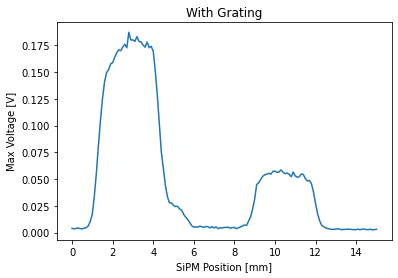

In [262]:
# Plot the data
distances = [distance_to_move*i for i in range(len(maxes))]
plt.plot(distances,maxes)
plt.title('With Grating')
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

Text(0.5, 0, 'SiPM Position [mm]')

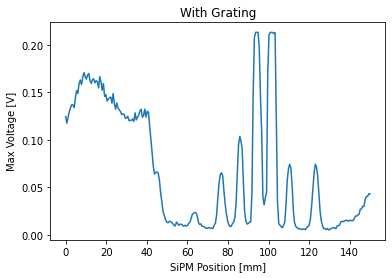

In [242]:
# Plot the data
distances = [distance_to_move*i for i in range(len(maxes))]
plt.plot(distances,maxes)
plt.title('With Grating')
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

Text(0.5, 0, 'SiPM Position [mm]')

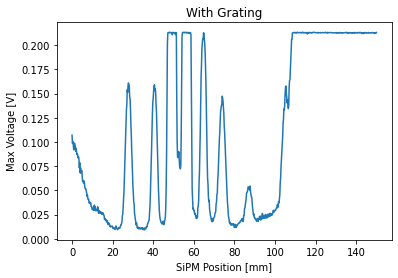

In [240]:
# Plot the data
distances = [distance_to_move*i for i in range(len(maxes))]
plt.plot(distances,maxes)
plt.title('With Grating')
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

## Plot the aquired data

Text(0.5, 0, 'SiPM Position [mm]')

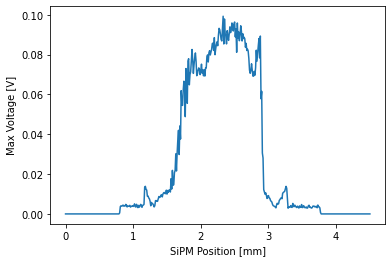

In [81]:
# Plot the data
distances = [distance_to_move*i for i in range(len(maxes))]
plt.plot(distances,maxes)
plt.ylabel('Max Voltage [V]')
plt.xlabel('SiPM Position [mm]')

In [ ]:
"""
With the SiPM and LED aligned, perform a full sweep to identify the position of the grating
"""
# Align SiPM and LED
print("Setting to bottom...")
SetToZero()
print("Aligning...")
MoveMotor(SIPM_OFFSET, 'sipm')
MoveMotor(80,"sipm")
MoveMotor(80,"led")
# The LED is currently at a lower position than the SiPM. So we move both together until the
# LED is within 5mm from the bottom.
distance_to_move = 80
distance_per_step = 0.5
num_steps = int(distance_to_move/distance_per_step)
maxes = []
positions_led = []
steps_led = []
# Measure voltage at each step
for i in range(num_steps):
    MoveMotor(distance_per_step, 'led')
    #time.sleep(2)
    MoveMotor(distance_per_step, 'sipm')
    #time.sleep(2)
    max = MeasurePeaktoPeak()
    maxes.append(max)
    current_position = GetCurrentPosition('led')
    current_steps = GetCurrentNumSteps('led')
    clear_output(wait=True)
    display(str(i+1)+"/"+str(num_steps)+": "+str(current_position)+" ("+str(max)+")")
    positions_led.append(current_position)
    steps_led.append(current_steps)
